[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Gedzelman_and_Arnold_1994/fig_2.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Gedzelman_and_Arnold_1994/fig_2.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Gedzelman_and_Arnold_1994/fig_2.ipynb)

#### based on Fig. 2 from Gedzelman and Arnold 1994 (JGR)  "_Modeling the isotopic composition of precipitation_"
https://doi.org/10.1029/93JD03518

**notes**:
- "b" defined in eq. (18) lacks multiplication by $\rho_\text{s}$ - units do not match, plot matches the one generated with $\rho_\text{s}$ included - seems a typo in eq. (18)

**extentions (see notebook cells below first figure):**
- multiple isotopes (D, $^{18}$O, $^{17}$O)
- modern parameterisations: Horita & Wesolowski '94 for D & $^{18}$O equil. fractionation, Barkan & Luz '05 for $^{17}$O, Hellmann & Harvey '20 for diffusivities
- environment ratio plot axis
- temperature dependence

In [1]:
import os, sys
os.environ['NUMBA_THREADING_LAYER'] = 'workqueue'  # PySDM & PyMPDATA don't work with TBB; OpenMP has extra dependencies on macOS
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples', 'PySDM')

In [2]:
from open_atmos_jupyter_utils import show_plot
from PySDM import Formulae
from PySDM.physics.constants import si, PER_MILLE, in_unit
from matplotlib import pyplot
import numpy as np
import copy

#### derivations:

- Maxwell-Mason equation (introducing $\rho_\text{s}=\frac{p_\text{vs}}{R_\text{v}T}$, approximated for $S_\text{eq}\approx 1$ and taking into account $\frac{l_\text{v}}{R_\text{v} T} \approx 20 \gg 1$):
$$
a\frac{da}{dt} 
= f \frac{
    S - S_\text{eq}
}{
    \rho_w \left(
        \frac{R_\text{v} T }{\Psi p_\text{vs}(T)} + 
        \frac{l_\text{v}}{K T} \left(\frac{l_\text{v}}{R_\text{v} T}-1\right)
    \right)
}
\approx \frac{f}{\rho_\text{w}} \frac{S - 1}{        \frac{1}{\Psi \rho_\text{s}} + 
        \frac{l^2_\text{v}}{K R_v T^2}
}
= \frac{f \Psi \rho_\text{s}}{\rho_\text{w}} \frac{S - 1}{        1 + 
        \frac{\Psi \rho_\text{s} l^2_\text{v}}{K R_v T^2}
}
$$
where $t$ is time, $a$ is drop radius, $f$ is ventilation factor, $\Psi$ is mass diffusion coefficient, $K$ thermal diffusion coefficient, $l_\text{v}$ is latent heat of condensation, $R_\text{v}$ gas constant for water vapour, $T$ temperature, $\rho_\text{w}$ density of water, $\rho_\text{s}$ saturation vapour density.

In [3]:
CONST = Formulae().constants
print(f"lv/(Rv T) at the triple point: {CONST.l_tri / (CONST.Rv * CONST.T_tri):.3g}")
CONST = None

lv/(Rv T) at the triple point: 19.8


- expressed in terms of mass $m=\frac{4}{3}\pi a^3 \rho_\text{w}$:

$$\frac{dm}{dt} / [\text{surface}]
= \frac{d\left(\frac{4}{3}\pi a^3 \rho_\text{w}\right)}{dt} \frac{1}{4 \pi a^2}
= \rho_\text{w} \frac{da}{dt}
$$

- introducing $b=\frac{l^2_\text{v} \Psi}{K R_\text{v}T^2}$ and approximating leads to eq. (16) in the paper:

$$
\frac{dm}{dt} 
\approx 4 \pi a \Psi f \rho_\text{s}\frac{S-1}{1 + b \rho_\text{s}}
$$

In [4]:
class Commons:  # pylint: disable=too-few-public-methods
    """ groups values used in both equations """
    def __init__(self, **kwargs):
        const = kwargs['formulae'].constants
        self.vsmow_ratio = getattr(const, f'VSMOW_R_{kwargs["isotope"]}')
        self.iso_ratio_v = kwargs['formulae'].trivia.isotopic_delta_2_ratio(kwargs['delta_v'], self.vsmow_ratio)
        alpha_fun = getattr(
            kwargs['formulae'].isotope_equilibrium_fractionation_factors,
            f'alpha_l_{kwargs["isotope"]}'
        )
        if kwargs['isotope'] == '17O':
            alpha_l_18O = kwargs['formulae'].isotope_equilibrium_fractionation_factors.alpha_l_18O(kwargs['T'])
            self.alpha_w = alpha_fun(np.nan, alpha_l_18O)
        else:
            self.alpha_w = alpha_fun(kwargs['T'])

        self.diff_coef_ratio = 1 / getattr(
            kwargs['formulae'].isotope_diffusivity_ratios,
            f'ratio_{kwargs["isotope"]}_heavy_to_light'
        )(kwargs['T'])

        missing_b_multiplier = (
            kwargs['formulae'].saturation_vapour_pressure.pvs_water(kwargs['T'])
            / kwargs['T']
            / const.Rv
        )
        self.b = (
            missing_b_multiplier
            * kwargs['formulae'].latent_heat_vapourisation.lv(kwargs['T'])**2
            * const.D0
            / const.K0
            / const.Rv
            / kwargs['T']**2
        )
        self.saturation_for_zero_dR_condition = kwargs['formulae'].isotope_ratio_evolution.saturation_for_zero_dR_condition
        any_number = 44.
        self.vent_coeff_ratio = kwargs['formulae'].isotope_ventilation_ratio.ratio_heavy_to_light(
            ventilation_coefficient=any_number,
            diffusivity_ratio_heavy_to_light=self.diff_coef_ratio
        )

class NoFractionationSaturation:  # pylint: disable=too-few-public-methods
    """ embodies eqs. (22) an (23) from the paper """
    def __init__(self, cmn: Commons, *, liquid: bool = False, vapour: bool = False):
        assert liquid != vapour
        self.liquid = liquid
        self.cmn = cmn
        
    def __call__(self, iso_ratio_r):
        return self.cmn.saturation_for_zero_dR_condition(
            iso_ratio_x=iso_ratio_r if self.liquid else self.cmn.iso_ratio_v,
            diff_rat_light_to_heavy = self.cmn.vent_coeff_ratio * self.cmn.diff_coef_ratio,
            b=self.cmn.b,
            alpha_w=self.cmn.alpha_w,
            iso_ratio_r=iso_ratio_r,
            iso_ratio_v=self.cmn.iso_ratio_v,
        )

In [5]:
paper_params = SimpleNamespace(
    formulae=Formulae(
        isotope_equilibrium_fractionation_factors='MerlivatAndNief1967',
        isotope_diffusivity_ratios='Stewart1975',
        isotope_ratio_evolution='GedzelmanAndArnold1994',
        isotope_ventilation_ratio='Neglect', # (this is not taken into account as it depends on droplet size which is not considered here)
    ),
    isotope='2H',
    delta_v= -200 * PER_MILLE,
    xlim=(.8, 1)
)
K2C = paper_params.formulae.trivia.K2C
C2K = paper_params.formulae.trivia.C2K
paper_params.T = C2K(10) * si.K
T_range = (C2K(-10) * si.K, C2K(30) * si.K)
Ts = np.linspace(*T_range, 9)

In [20]:

def plot(*, ax,x, ys, xlim, params: SimpleNamespace):
    temp_01 = (params.T - T_range[0])/(T_range[1] - T_range[0])
    color = (temp_01, .333, 1-temp_01)
    iso_latex = f"^{{{params.isotope[:-1]}}}{params.isotope[-1]}"
    for y, label in zip(ys, [(r'S$_R$(eq)'), (r'S$_V$(eq)')]):
        ax.plot(x, y, label=label, color=color)
    ax.set(
        title=f"ambient vapour $\\delta{iso_latex}$ = {in_unit(params.delta_v, PER_MILLE):.3g}‰",
        ylim=(0, 1),
        yticks=np.linspace(0, 1, 5),
        xlabel=f'${iso_latex}$: R$_{{rain}}$ / R$_{{SMOW}}$',
        ylabel='S=RH',
        xlim=xlim,
    )
    ax.grid(visible=True, axis='both')

    
    return x, {'eq_22': y_eq_22, 'eq_23': y_eq_23}

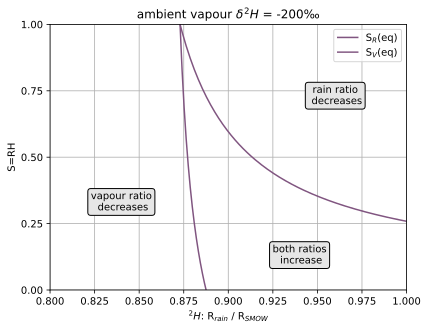

In [21]:
params=copy.deepcopy(paper_params)
commons = Commons(**vars(params))
x = np.linspace(commons.alpha_w * commons.iso_ratio_v / commons.vsmow_ratio, 1.1, 200)
y_eq_22 = NoFractionationSaturation(commons, liquid=True)(x * commons.vsmow_ratio)
y_eq_23 = NoFractionationSaturation(commons, vapour=True)(x * commons.vsmow_ratio)
fig2_x, fig2_y = plot(
    ax=pyplot.gca(),
    x=x,
    ys=(y_eq_22, y_eq_23),
    xlim=params.xlim,
    params=params,
)
# 
# if temperature_label:
#         ax.annotate(
#             f' {K2C(commons_kwargs["temperature"]):g}°C$\\!\\!\\!\\!\\!\\!$',
#             (xlim[-1], y_eq_22[-1] - .015),
#             fontsize=8
#         )
pyplot.legend()

annotate_kwargs = {'bbox': {'boxstyle': 'round', 'fc': '0.9'}, 'ha': 'center'}
pyplot.annotate(text="vapour ratio\n decreases", xy=(.84, .3), **annotate_kwargs)
pyplot.annotate(text="rain ratio\n decreases", xy=(.96, .7), **annotate_kwargs)
pyplot.annotate(text="both ratios\n increase", xy=(.94, .1), **annotate_kwargs)

show_plot('fig_2.pdf')

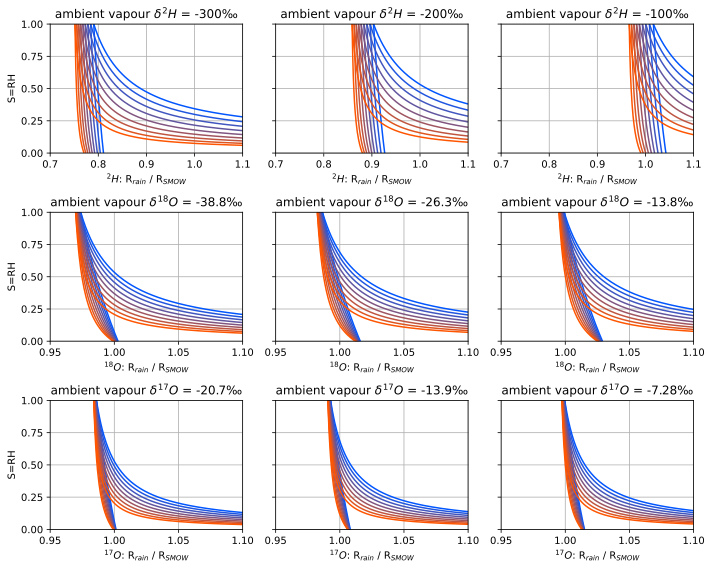

In [22]:
params = copy.deepcopy(paper_params)
params.formulae = Formulae(
    isotope_equilibrium_fractionation_factors='BarkanAndLuz2005+HoritaAndWesolowski1994',
    isotope_diffusivity_ratios='HellmannAndHarvey2020',
    isotope_meteoric_water_line='BarkanAndLuz2007+Dansgaard1964',
    isotope_ratio_evolution='GedzelmanAndArnold1994',
    isotope_ventilation_ratio='Neglect', # (this is not taken into account as it depends on droplet size which is not considered here)
)
iso_mwl=params.formulae.isotope_meteoric_water_line
deltas_2H = (-300 * PER_MILLE, -200 * PER_MILLE, -100 * PER_MILLE)
deltas_18O = [iso_mwl.d18O_of_d2H(d2H) for d2H in deltas_2H]
deltas_17O = [iso_mwl.d17O_of_d18O(d18O) for d18O in deltas_18O]

fig, axs = pyplot.subplots(3, 3, figsize=(10,8), sharex=False, sharey=True, tight_layout=True) 

for ax_idx_iso, iso_label in enumerate(('2H', '18O', '17O')):
    for ax_idx_delta, delta_v in enumerate({
        '2H': deltas_2H,
        '18O': deltas_18O,
        '17O': deltas_17O,
    }[iso_label]):
        params.delta_v = delta_v
        params.isotope = iso_label
        for i, temperature in enumerate(Ts):
            params.T = temperature
            commons = Commons(**vars(params))
            x = np.linspace(commons.alpha_w * commons.iso_ratio_v / commons.vsmow_ratio, 1.1, 200)
            y_eq_liq = NoFractionationSaturation(commons, liquid=True)(x * commons.vsmow_ratio)
            y_eq_vap = NoFractionationSaturation(commons, vapour=True)(x * commons.vsmow_ratio)
            plot(
                ax=axs[ax_idx_iso][ax_idx_delta],
                x=x,
                ys=(y_eq_liq, y_eq_vap),
                xlim={
                    '2H': (.7, 1.1),
                    '18O': (.95, 1.1),
                    '17O': (.95, 1.1),
                }[iso_label],
                params=params,
            )        
        if ax_idx_delta != 0:
            axs[ax_idx_iso][ax_idx_delta].set_ylabel('')
show_plot('plot_grid.pdf')